This is supporting data for Stringari and Power (2019) - Under Review

In [1]:
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------
#
# SCRIPT   : update_mlp.py
# POURPOSE : updated the MLP model from Stringari and Power (2019) with new
#            data
#
# AUTHOR   : Caio Eadi Stringari
# EMAIL    : Caio.EadiStringari@uon.edu.au
#
# v1.0     : 06/04/2019 [Caio Stringari]
#
# ------------------------------------------------------------------------
# ------------------------------------------------------------------------


In [2]:
# System
import os
import sys
import subprocess

from matplotlib.dates import date2num

# Arguments
import argparse

# Numpy
import numpy as np
import pandas as pd

# Machine learning
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.externals import joblib
from imblearn.combine import SMOTETomek
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, r2_score
from imblearn.metrics import classification_report_imbalanced

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 2.0})
sns.set_style("ticks", {'axes.linewidth': 2,
                        'legend.frameon': True,
                        'axes.facecolor': "#E9E9F1",
                        'grid.color': "w"})
mpl.rcParams['axes.linewidth'] = 2
plt.rcParams['patch.edgecolor'] = '0.5'

Using TensorFlow backend.
/home/stringari/python/envs/phd/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
def split_train_test(df, features, balance=True,
                     test_size=0.3, train_size=0.7, return_data=True):
    """
    Split the input dataframe (df) into train and test datasets. Respect data
    probability distribution for each class and, if requested, balance the
    classes using the SMOTETomek method. This function is specific to the
    broken wave classification problem. The columns "broken" (y) and "location"
    must be in the input dataframe.

    if return_data == False:

        write the follwing:

        X_train.csv: training X dataset. Shape is n_samples x n_features
        X_test.csv: training y dataset (i.e., broken(1) or unbroken (0))
        y_train.csv: testing X dataset. Shape is n_samples x n_features
        y_test.csv: testing y dataset (i.e., broken(1) or unbroken (0))
        locations_train.csv: auxiliary "locations" dataset for training data
        locations_train.csv: auxiliary "locations" dataset for testing data

        This strategy should avoid OOM problems.

    ----------
    Args:
        df (Mandatory [pd.DataFrame]): input data frame

        features (Mandatory [np.array]): a array of strings containg the fea-
                                         tures names (i.e.) column names
                                         to use in the training process.

        labels (Optional [bool]): if True, use SMOTETomek to balance the
                                  classes.

        test_size, train_size (Optional [float]): train and test fractions.

        return_data (Optional [boll]): if true, return data. Else, write to
                                       file

    ----------
    Returns:
        If return is true:
        X_train (Mandatory [np.ndarray]): training X dataset. Shape is
                                          n_samples x n_features

        X_test (Mandatory [np.ndarray]): training y dataset (i.e., broken(1) or
                                         unbroken (0))

        y_train (Mandatory [np.ndarray]): testing X dataset. Shape is
                                          n_samples x n_features

        y_test (Mandatory [np.ndarray]): testing y dataset (i.e., broken(1) or
                                         unbroken (0))
    """

    # select only user parameters
    df = df[features]

    # group by location
    groups = df.groupby("location")

    # loop over locations
    dfXtrain = []
    dfXtest = []
    dfytrain = []
    dfytest = []
    dfLoctrain = []
    dfLoctest = []
    for g, gdf in groups:
        # print("  ++> processing :", g)
        # get the locations and drop the location from the df
        df1 = gdf.drop("location", axis=1)
        # get the labels
        y = df1["broken"].values
        # get X and y values at each location
        df2 = df1.drop("broken", axis=1)
        X = df2.values
        # do the split
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                        test_size=test_size,
                                                        train_size=train_size,
                                                        shuffle=True,
                                                        stratify=y)
        if balance:
            # balance the training classes
            resampler = SMOTETomek()
            Xtrain_b, ytrain_b = resampler.fit_sample(Xtrain, ytrain)
            Xtest_b, ytest_b = resampler.fit_sample(Xtest, ytest)
        else:
            Xtrain_b = Xtrain
            ytrain_b = ytrain
            Xtest_b = Xtest
            ytest_b = ytest

        # append to output
        dfXtrain.append(pd.DataFrame(Xtrain_b, columns=df2.columns))
        dfXtest.append(pd.DataFrame(Xtest_b, columns=df2.columns))
        dfytrain.append(pd.DataFrame(ytrain_b, columns=["label"]))
        dfytest.append(pd.DataFrame(ytest_b, columns=["label"]))
        dfLoctrain.append(pd.DataFrame([g]*len(ytrain_b),
                                       columns=["location"]))
        dfLoctest.append(pd.DataFrame([g]*len(ytest_b),
                                      columns=["location"]))

    # concatenate
    df_X_train = pd.concat(dfXtrain)
    df_X_test = pd.concat(dfXtest)
    df_y_train = pd.concat(dfytrain)
    df_y_test = pd.concat(dfytest)
    df_l_train = pd.concat(dfLoctrain)
    df_l_test = pd.concat(dfLoctest)

    # output
    if return_data:
        return df_X_train.values, df_X_test.values, \
            df_y_train.values, df_y_test.values
    else:
        df_X_train.to_csv("X_train.csv", index=False)
        df_X_test.to_csv("X_test.csv", index=False)
        df_y_train.to_csv("y_train.csv", index=False)
        df_y_test.to_csv("y_test.csv", index=False)
        df_l_train.to_csv("locations_train.csv", index=False)
        df_l_test.to_csv("locations_test.csv", index=False)

In [4]:
def get_Qb_from_table(df):
    """
    Loop over the input table, group data by location and then by PT,
    and creates a list of dictonaries in which element is a dataset to test
    against the theories.
    """
    QB = []
    Hue = []
    # fid_grp = [1, 2 ,3]
    for location, dfloc in df.groupby("location"):
        for PT, dfpt in dfloc.groupby("PT"):
            # get fids
            for fid_grp in group(dfpt["FID"].unique(), 2):

                # this contains X minutes of wave data
                dffid = dfpt.loc[dfpt["FID"].isin(fid_grp)]

                # true Qb values
                brokens = len(np.where(dffid["broken"].values == 1)[0])
                qb = brokens/dffid["broken"].count()

                # append to the full list
                QB.append(qb)
                Hue.append(dffid["location"].values[0])
    return np.array(QB), np.array(Hue)

In [5]:
def group(lst, n):
    """
    Group a list into consecutive n-tuples. Incomplete tuples are
    discarded e.g.

    ([0,3,4,10,2,3], 2) => [(0,3), (4,10), (2,3)]

    ----------
    Args:
        lst (Mandatory [list]): input list

        n   (Mandatory [int]): number of elements in the sublist

    Returns:
        zipped (Mandatory [iteratable]): a zip iterator.
    """
    return zip(*[lst[i::n] for i in range(n)])

W0709 15:54:02.071599 140665409214272 deprecation_wrapper.py:119] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 15:54:02.085212 140665409214272 deprecation_wrapper.py:119] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 15:54:02.087326 140665409214272 deprecation_wrapper.py:119] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0709 15:54:02.168357 140665409214272 deprecation_wrapper.py:119] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Plea


Training classifier, please wait...

 [1/7] Loading previous model



W0709 15:54:02.429206 140665409214272 deprecation_wrapper.py:119] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0709 15:54:02.437819 140665409214272 deprecation.py:323] From /home/stringari/python/envs/phd/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 [2/7] Reading new data

 [3/7] Splitting and scaling new data

 [4/7] Training...

  [5/7] Classification report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       555
           1       0.94      0.94      0.94       555

    accuracy                           0.94      1110
   macro avg       0.94      0.94      0.94      1110
weighted avg       0.94      0.94      0.94      1110

  [6/7] Serializing updated model:

  [7/7] Plotting and saving results



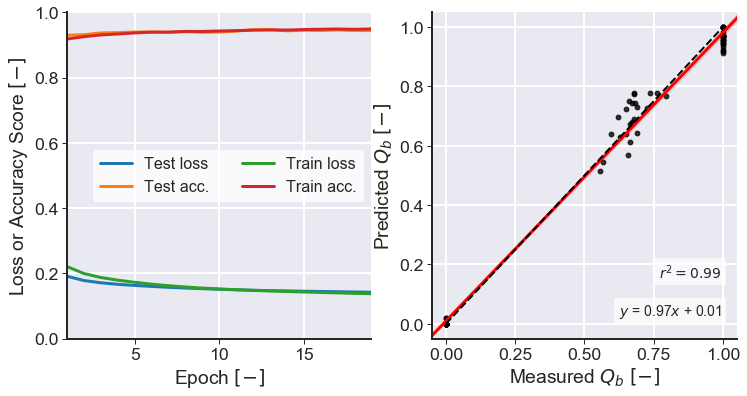

In [6]:
    print("\nTraining classifier, please wait...\n")

    # CONSTANTS #

    FEATURES = ["crest_depth",
                "trough_depth_a",
                "trough_depth_b",
                "wave_height",
                "wave_period",
                "wave_steepness",
                "wave_skewness",
                "wave_kurtosis",
                "ursell_number",
                "trough_depth_gamma",
                "wavenumber",
                "angular_frequency",
                "wavelenght",
                "a",
                "b",
                "va",
                "b0",
                "location",
                "broken"]
    TEST_SIZE = 0.2
    TRAIN_SIZE = 0.8
    BALANCE = True  # If true, balance the classes
    EPOCHS = 20  # number of epochs for the ANN
    BATCH_SIZE = 1024  # data batch size for training

    print(" [1/7] Loading previous model\n")

    # previously trained model
    model = "MLP.json"
    weights = "MLP.h5"
    train_data = "TRAIN_DATA.csv"

    # load json and create model
    json_file = open(model, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(weights)

    # build a global scaler
    df = pd.read_csv(train_data)
    features = []
    for f in FEATURES:
        if f not in ["location", "broken"]:
            features.append(f)
    scaler = MinMaxScaler().fit(df[features])

    print(" [2/7] Reading new data\n")
    up = pd.read_csv("UPDATE_DATA.csv")

    # scale new data
    print(" [3/7] Splitting and scaling new data\n")
    X_train, X_test, y_train, y_test = split_train_test(up, FEATURES,
                                                        balance=BALANCE,
                                                        train_size=TRAIN_SIZE,
                                                        test_size=TEST_SIZE)
    # scale each feature from 0 to 1
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # all data new data
    Xall = up[FEATURES[:-2]].values
    X_all = scaler.transform(Xall)

    # train
    print(" [4/7] Training...\n")
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=adam,
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_test, y_test),
                        verbose=0,)

    y_pred = model.predict_classes(X_test)

    print("  [5/7] Classification report:\n")
    print(classification_report(y_pred, y_test))

    print("  [6/7] Serializing updated model:\n")
    # serialize model to JSON
    current_model = "wave_classifier"
    model_json = model.to_json()
    with open(current_model+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    current_model = "wave_weights"
    model.save_weights(current_model+".h5")
    # serialize scaler
    dfm = pd.concat([df, up])
    scaler = MinMaxScaler().fit(dfm[features])
    joblib.dump(scaler, "wave_scaler.data")

    print("  [7/7] Plotting and saving results\n")
    # Qb calculations
    Qb_true, locations = get_Qb_from_table(up)

    # Qb from learned labels
    df_hat = up
    df_hat["broken"] = np.squeeze(model.predict_classes(X_all))
    Qb_hat, locations = get_Qb_from_table(df_hat)
    Qb_hat = np.hstack([Qb_hat, [0, 0, 0, 1, 1, 1]])
    Qb_true = np.hstack([Qb_true, [0, 0, 0, 1, 1, 1]])

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # predictions
    sns.regplot(Qb_true, Qb_hat, color="r", scatter_kws={"color": "k"})
    ax2.plot((0, 1), (0, 1), color="k", ls="--", lw=2)
    ax2.grid(color="w", ls="-", lw=2)

    # plot learning curves
    t = np.linspace(1, EPOCHS-1, EPOCHS-1).astype(int)
    labels = ['Test loss', 'Test acc.', 'Train loss', 'Train acc.']
    for i, par in enumerate(history.history.keys()):
        ax1.plot(t, np.array(history.history[par])[t], label=labels[i], lw=3)
    ax1.grid(color="w", ls="-", lw=2)
    lg = ax1.legend(loc="best", ncol=2, fontsize=16)
    lg.get_frame().set_color("w")

    # add regression values to the plot
    M = LinearRegression(fit_intercept=True)
    M.fit(Qb_true.reshape(-1, 1), Qb_hat.reshape(-1, 1))

    r = np.round(r2_score(Qb_hat, Qb_true), 2)
    if np.round(r, 2) == 1:
        r = 0.99
    bbox = dict(boxstyle="square", ec="none", fc="1", lw=1, alpha=0.7)
    text1 = r"$r^{2}$"+r"$ = {0:.2f}$".format(r)
    text2 = r"$y$ = " + "{0:.2f}".format(
        M.coef_[0][0]) + r"$x$ + " + "{0:.2f}".format(M.intercept_[0])
    ax2.text(0.95, 0.205, text1, transform=ax2.transAxes, ha="right",
             va="center", bbox=bbox, zorder=100, fontsize=14)
    ax2.text(0.95, 0.085, text2, transform=ax2.transAxes, ha="right",
             va="center", bbox=bbox, zorder=100, fontsize=14)

    ax1.set_xlim(1, EPOCHS-1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel(r"Epoch $[-]$")
    ax1.set_ylabel(r"Loss or Accuracy Score $[-]$")

    ax2.set_xlim(-0.05, 1.05)
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlabel(r"Measured $Q_b$ $[-]$")
    ax2.set_ylabel(r"Predicted $Q_b$ $[-]$")

    sns.despine(ax=ax1)
    sns.despine(ax=ax2)

    plt.show()